In [0]:
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional
from torchvision import transforms, models
from PIL import Image

In [2]:
!wget -O skyline.jpg https://www.atterrir.com/wp-content/uploads/2015/11/vancouver-skyline.jpg
!wget -O supermarket.jpg https://raw.githubusercontent.com/eriklindernoren/PyTorch-Deep-Dream/master/images/supermarket.jpg
!wget -O flowers.jpg http://www.challengemagazine.com/wp-content/uploads/2016/06/1.jpg

--2020-02-12 17:34:56--  https://www.atterrir.com/wp-content/uploads/2015/11/vancouver-skyline.jpg
Resolving www.atterrir.com (www.atterrir.com)... 104.26.8.4, 104.26.9.4, 2606:4700:20::681a:804, ...
Connecting to www.atterrir.com (www.atterrir.com)|104.26.8.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307801 (301K) [image/jpeg]
Saving to: ‘skyline.jpg’

skyline.jpg         100%[===================>] 300.59K   927KB/s    in 0.3s    

2020-02-12 17:34:57 (927 KB/s) - ‘skyline.jpg’ saved [307801/307801]

--2020-02-12 17:34:59--  https://raw.githubusercontent.com/eriklindernoren/PyTorch-Deep-Dream/master/images/supermarket.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72732 (71K) [image/jpeg]
Saving to: ‘supermarket.jpg’

superma

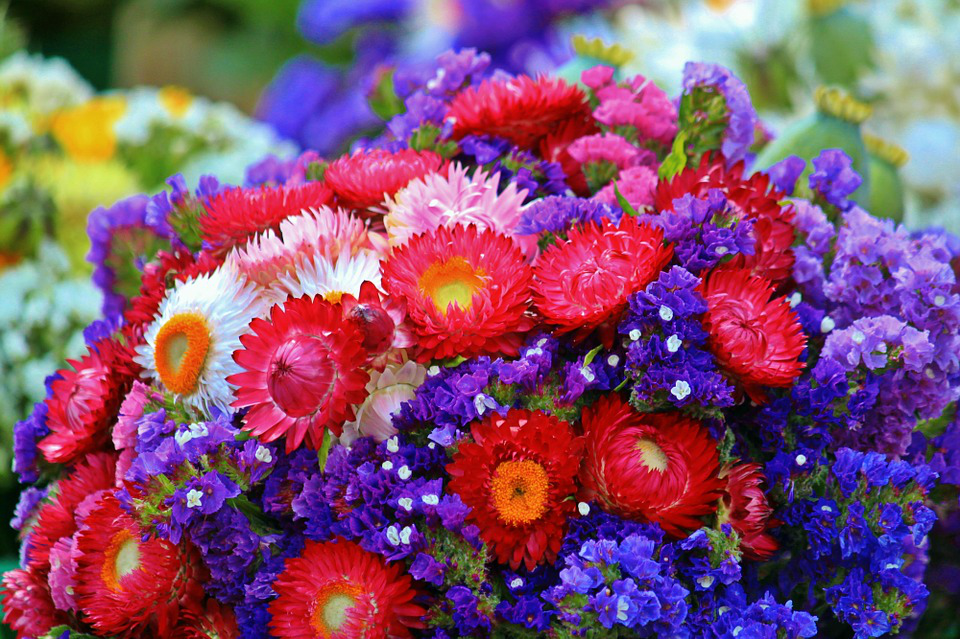

In [3]:
img = Image.open('flowers.jpg')
img

In [4]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
input = tfms(img).unsqueeze(0).cuda()
input.shape

torch.Size([1, 3, 639, 960])

In [5]:
input.min(), input.max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [6]:
n_octaves = 10
n_octaves_until = 0
octave_zoom = 1.5
iterations = 20
blend = 1.
lr = 0.03

# net = models.resnet18(pretrained=True)
# layers = list(net.children())[:5]


net = models.vgg19(pretrained=True)
layers = list(net.features.children())[:28]


net = nn.Sequential(*layers).cuda()
for i in net.parameters():
  i.requires_grad_(False)

layers

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [0]:
def apply_to_img(img):
  noise = torch.zeros(img.shape, requires_grad=True, dtype=torch.float64).cuda()
  next = img.cuda().clone()
  next.requires_grad_(True)
  for _ in range(iterations):
    loss = (net(next) ** 2).mean()
    # loss = net(next).norm() ** 2
    # print(loss)
    loss.backward()
    with torch.no_grad():
      next += next.grad * lr / next.grad.abs().mean()
      next.grad.data.zero_()
  next.requires_grad_(False)
  return next

octave zoom 10
  scaling to 0.02601229487374892
octave zoom 9
  scaling to 0.03901844231062338


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


octave zoom 8
  scaling to 0.05852766346593507
octave zoom 7
  scaling to 0.0877914951989026
octave zoom 6
  scaling to 0.13168724279835392
octave zoom 5
  scaling to 0.19753086419753085
octave zoom 4
  scaling to 0.2962962962962963
octave zoom 3
  scaling to 0.4444444444444444
octave zoom 2
  scaling to 0.6666666666666666
octave zoom 1
  scaling to 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


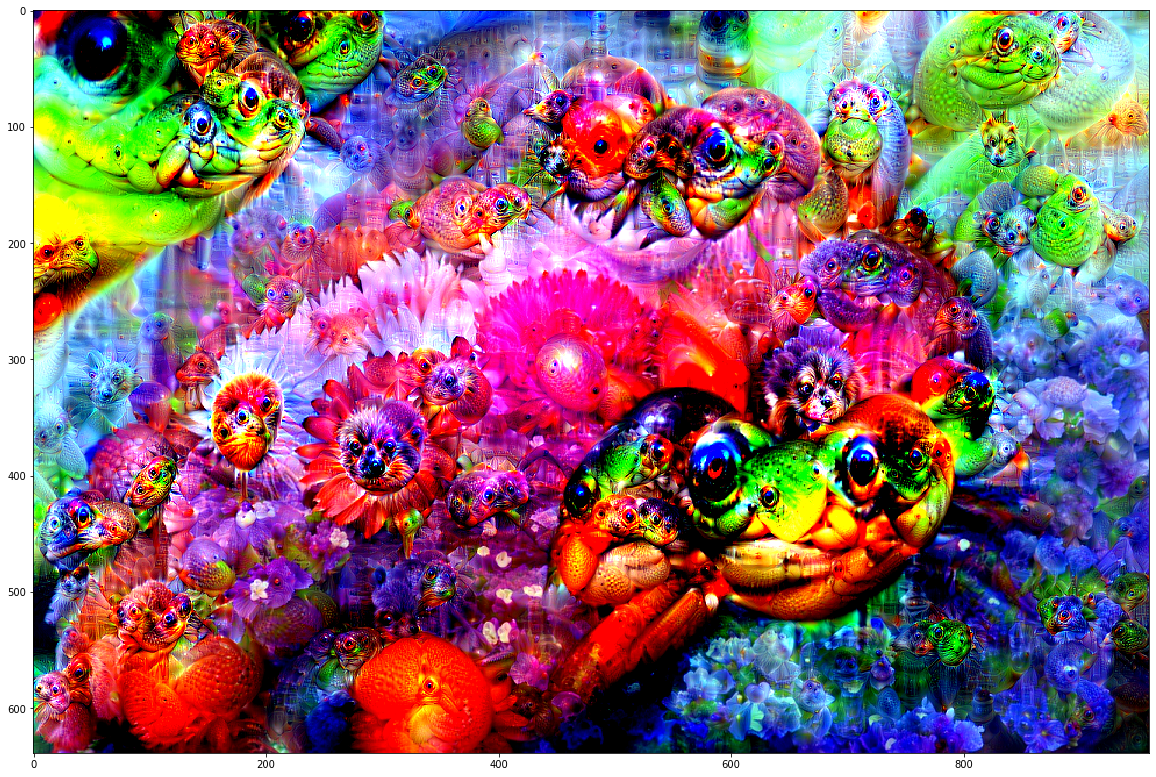

In [8]:
last_diff = None
blur_matrix = torch.ones((1, 3, 3, 3)).cuda()
blur_matrix[0, :, 1, 1] = 20
blur_matrix /= blur_matrix.sum()

for scale_n in range(n_octaves, n_octaves_until, -1):
  print('octave zoom', scale_n)
  scale = octave_zoom ** (scale_n - 1)
  print('  scaling to', 1. / scale)
  interp = nn.functional.interpolate(input, scale_factor=1. / scale, mode='bilinear')
  cur = interp.clone()# * blend
  if last_diff is not None:
     cur += nn.functional.interpolate(last_diff, size=cur[0, 0].shape, mode='bilinear')
  for i in range(3):
    cur[0][i].clamp_(1. / -std[i], 1. / std[i])
  dream = apply_to_img(cur)
  diff = dream - interp
  last_diff = diff

final_diff = nn.functional.interpolate(last_diff, size=input[0, 0].shape, mode='bilinear')
# final_diff = nn.functional.conv2d(final_diff, blur_matrix, padding=1)
_, ax = plt.subplots(figsize=(20,20))
ax.imshow(((input[0] + final_diff[0]).cpu() * std.reshape(3, 1, 1) + mean.reshape(3, 1, 1)).permute(1, 2, 0))

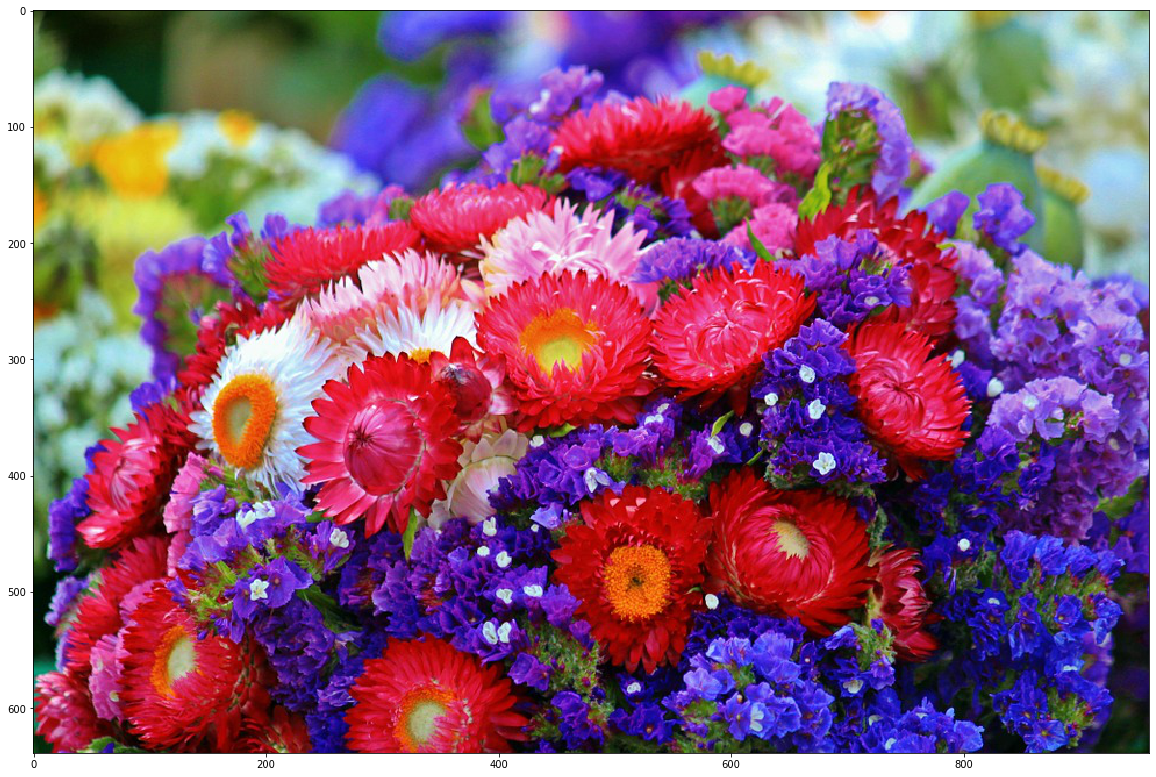

In [9]:
_, ax = plt.subplots(figsize=(20,20))
ax.imshow(((input[0]).cpu() * std.reshape(3, 1, 1) + mean.reshape(3, 1, 1)).permute(1, 2, 0))

In [10]:
print(final_diff[0].shape, blur_matrix.shape)
nn.functional.conv2d(final_diff, blur_matrix, stride=1)

torch.Size([3, 639, 960]) torch.Size([1, 3, 3, 3])


tensor([[[[-1.0560e+00, -8.8600e-01, -7.5029e-01,  ..., -1.3325e-01,
           -6.2840e-02,  2.3069e-01],
          [-1.0747e+00, -9.8087e-01, -8.2726e-01,  ..., -5.6033e-02,
            5.2373e-02,  7.5769e-02],
          [-1.1971e+00, -1.0283e+00, -9.5150e-01,  ...,  3.3107e-02,
           -3.7995e-04, -8.7286e-02],
          ...,
          [ 6.0531e-01,  6.1013e-01,  5.5455e-01,  ..., -2.8080e-01,
           -2.3843e-01, -2.6950e-01],
          [ 6.5540e-01,  6.7886e-01,  6.7401e-01,  ..., -2.7624e-01,
           -2.7776e-01, -3.3876e-01],
          [ 6.7160e-01,  6.1370e-01,  6.1857e-01,  ..., -2.9837e-01,
           -3.1947e-01, -3.5188e-01]]]], device='cuda:0')